In [18]:
# Instead of using Client, use the functions directly from the binance module
import binance as bnb
import pandas as pd
import datetime
import requests
import os
from dotenv import load_dotenv

def get_exchange_info():
    """Get exchange information from Binance API"""
    info = requests.get('https://api.binance.com/api/v3/exchangeInfo')
    return info.json()

def create_overview_df(info):
    """Create overview DataFrame from exchange info"""
    symbols_df = pd.DataFrame(info['symbols'])
    overview_df = symbols_df[[
        'symbol',
        'baseAsset', 
        'quoteAsset',
        'status',
        'baseAssetPrecision',
        'quotePrecision'
    ]]
    return overview_df[overview_df.status == 'TRADING']

def setup_binance_client():
    """Setup Binance API client"""
    load_dotenv()
    apiKey = os.getenv('BinanceAPIKey')
    secret = os.getenv('BinanceAPISecret')
    client = bnb.Client(api_key=apiKey, api_secret=secret)
    return client


def get_tickers_df(client, overview_df):
    """Get tickers data and convert to DataFrame"""
    all_tickers = client.get_all_tickers()
    tickers_df = pd.DataFrame(all_tickers)
    trading_symbols = overview_df['symbol']
    tickers_df = tickers_df[tickers_df['symbol'].isin(trading_symbols)]
    tickers_df['price'] = pd.to_numeric(tickers_df['price'], errors='coerce')
    
    return tickers_df

def split_pair(pair):
    """Split trading pair into base and quote currencies"""
    quote_currencies = ['USDT', 'USDC', 'BTC', 'ETH']
    for quote in quote_currencies:
        if pair.endswith(quote):
            return pair[:-len(quote)], quote
    return pair, None

def create_arbitrage_matrix(tickers_df):
    """Create arbitrage matrix from tickers data"""
    # Create base and quote columns
    tickers_df[['Base', 'Quote']] = tickers_df['symbol'].apply(lambda x: pd.Series(split_pair(x)))
    
    # Filter quotes and create pivot table
    tickers_df = tickers_df[tickers_df['Quote'].isin(['USDT', 'USDC', 'BTC', 'ETH'])]
    arbitrage_matrix = tickers_df.pivot(index='Base', columns='Quote', values='price')
    
    # Format matrix
    arbitrage_matrix.reset_index(inplace=True)
    arbitrage_matrix.columns.name = None
    arbitrage_matrix = arbitrage_matrix.rename(columns={'Base': 'COIN'})
    
    # Ensure column order
    cols = ['COIN', 'BTC', 'ETH', 'USDC', 'USDT']
    return arbitrage_matrix.reindex(columns=cols)

def get_arbitrage_matrix():
    """Main function to run the analysis"""
    # Get exchange info and create overview DataFrame
    info = get_exchange_info()
    overview_df = create_overview_df(info)
    
    # Setup client and get tickers data
    client = setup_binance_client()
    tickers_df = get_tickers_df(client,overview_df)
    
    # Create and return arbitrage matrix
    arbitrage_matrix = create_arbitrage_matrix(tickers_df)
    return arbitrage_matrix
def create_base_conversion_matrix(arbitrage_matrix):
    """Create initial conversion matrix with base currencies"""
    base_currencies = ['BTC', 'ETH', 'USDC', 'USDT']
    conversion_matrix = arbitrage_matrix[arbitrage_matrix['COIN'].isin(base_currencies)]
    
    # Set diagonal values to 1
    for currency in base_currencies:
        conversion_matrix.loc[conversion_matrix['COIN'] == currency, currency] = 1
        
    return conversion_matrix

def calculate_cross_rates(conversion_matrix):
    """Calculate cross-rates between currencies"""
    # Calculate BTC/ETH rate
    btc_eth = 1/float(conversion_matrix.loc[conversion_matrix['COIN'] == 'ETH', 'BTC'].iloc[0])
    conversion_matrix.loc[conversion_matrix['COIN'] == 'BTC', 'ETH'] = btc_eth
    
    # Calculate USDC/BTC rate
    usdc_btc = 1/float(conversion_matrix.loc[conversion_matrix['COIN'] == 'BTC', 'USDC'].iloc[0])
    conversion_matrix.loc[conversion_matrix['COIN'] == 'USDC', 'BTC'] = usdc_btc
    
    # Calculate USDC/ETH rate
    usdc_eth = 1/float(conversion_matrix.loc[conversion_matrix['COIN'] == 'ETH', 'USDT'].iloc[0])
    conversion_matrix.loc[conversion_matrix['COIN'] == 'USDC', 'ETH'] = usdc_eth
    
    return conversion_matrix

# Create and populate conversion matrix

# Run analysis
arbitrage_matrix = get_arbitrage_matrix()
conversion_matrix = create_base_conversion_matrix(arbitrage_matrix)
conversion_matrix = calculate_cross_rates(conversion_matrix)
conversion_matrix


,COIN,BTC,ETH,USDC,USDT
74,BTC,1.000000,41.963911,111528.01,111506.6300
126,ETH,0.023830,1.000000,2657.31,2656.9600
360,USDC,0.000009,0.000376,1.00,0.9999


In [2]:
arbitrage_matrix = get_arbitrage_matrix()
conversion_matrix = create_base_conversion_matrix(arbitrage_matrix)
conversion_matrix = calculate_cross_rates(conversion_matrix)
conversion_matrix
df = arbitrage_matrix.dropna()
df.columns = ['COIN','BTC_actual', 'ETH_actual', 'USDC_actual', 'USDT_actual']

def get_coin_price_USDT(coin):
    coin_usdt = df[df['COIN'] == coin]['USDT_actual'].values[0]
    return coin_usdt

def get_coin_price_BTC(coin):
    coin_btc = df[df['COIN'] == coin]['BTC_actual'].values[0]
    return coin_btc

def get_coin_price_ETH(coin):
    coin_eth = df[df['COIN'] == coin]['ETH_actual'].values[0]
    return coin_eth

def get_coin_price_USDC(coin):
    coin_usdc = df[df['COIN'] == coin]['USDC_actual'].values[0]
    return coin_usdc

def convert(source = 'BTC', destination = 'ETH', amount = 1, conversion_matrix = conversion_matrix):
    """Convert amount from one currency to another"""
    conversion_rate = conversion_matrix.loc[conversion_matrix['COIN'] == source, destination].values[0]
    return amount * conversion_rate


balance = 100
loops = 100
for i in range(len(df)):
    coin = df.iloc[i]['COIN']
    starting_quantitiy = 100/get_coin_price_USDT(coin)

    # GALA -> USDT
    path1 = get_coin_price_USDT(coin)*starting_quantitiy

    # GALA -> BTC -> USDT
    path2 = get_coin_price_BTC(coin)*starting_quantitiy
    path2 = convert(source = 'BTC', destination = 'USDT', amount = path2)

    # GALA -> ETH -> USDT
    path3 = get_coin_price_ETH(coin)*starting_quantitiy
    path3 = convert(source = 'ETH', destination = 'USDT', amount = path3)

    # GALA -> USDC -> USDT
    path4 = get_coin_price_USDC(coin)*starting_quantitiy
    path4 = convert(source = 'USDC', destination = 'USDT', amount = path4)

    if (path2 - path1 > 0.02) or (path3 - path1 > 0.02) or (path4 - path1 > 0.02):
        max_path = max(path2, path3, path4)
        profit = max_path - path1
        profit_percentage = (profit / path1) * 100
        print(
            f"""    
            Starting with {starting_quantitiy} {coin}:
            Direct path ({coin} -> USDT): {path1:.4f} USDT
            Best path value: {max_path:.4f} USDT
            Potential profit: {profit:.4f} USDT ({profit_percentage:.2f}%)
            
            All paths:
            {coin} -> USDT: {path1:.4f} USDT
            {coin} -> BTC -> USDT: {path2:.4f} USDT
            {coin} -> ETH -> USDT: {path3:.4f} USDT 
            {coin} -> USDC -> USDT: {path4:.4f} USDT
            """
        )




    
            Starting with 0.39357682619647355 AAVE:
            Direct path (AAVE -> USDT): 100.0000 USDT
            Best path value: 100.1766 USDT
            Potential profit: 0.1766 USDT (0.18%)
            
            All paths:
            AAVE -> USDT: 100.0000 USDT
            AAVE -> BTC -> USDT: 99.9441 USDT
            AAVE -> ETH -> USDT: 100.1766 USDT 
            AAVE -> USDC -> USDT: 99.9643 USDT
            
    
            Starting with 234.6866932644919 ARB:
            Direct path (ARB -> USDT): 100.0000 USDT
            Best path value: 100.1301 USDT
            Potential profit: 0.1301 USDT (0.13%)
            
            All paths:
            ARB -> USDT: 100.0000 USDT
            ARB -> BTC -> USDT: 99.9336 USDT
            ARB -> ETH -> USDT: 100.1301 USDT 
            ARB -> USDC -> USDT: 100.0504 USDT
            
    
            Starting with 19.50078003120125 ATOM:
            Direct path (ATOM -> USDT): 100.0000 USDT
            Best path value: 1

In [3]:

arbitrage_matrix = get_arbitrage_matrix()
conversion_matrix = create_base_conversion_matrix(arbitrage_matrix)
conversion_matrix = calculate_cross_rates(conversion_matrix)
df = arbitrage_matrix.dropna()
df.columns = ['COIN','BTC_actual', 'ETH_actual', 'USDC_actual', 'USDT_actual']

def simulate_repeated_arbitrage(initial_balance=100, loops=100):
    """Simulate repeated arbitrage through the most profitable path"""
    results = []
    
    for i in range(len(df)):
        coin = df.iloc[i]['COIN']
        current_balance = initial_balance
        
        # Calculate one-time paths to find the most profitable
        starting_quantity = initial_balance/get_coin_price_USDT(coin)
        
        # GALA -> USDT
        path1 = get_coin_price_USDT(coin)*starting_quantity
        
        # GALA -> BTC -> USDT
        path2 = get_coin_price_BTC(coin)*starting_quantity
        path2 = convert(source='BTC', destination='USDT', amount=path2)
        
        # GALA -> ETH -> USDT
        path3 = get_coin_price_ETH(coin)*starting_quantity
        path3 = convert(source='ETH', destination='USDT', amount=path3)
        
        # GALA -> USDC -> USDT
        path4 = get_coin_price_USDC(coin)*starting_quantity
        path4 = convert(source='USDC', destination='USDT', amount=path4)
        
        # Find the most profitable path
        paths = [path1, path2, path3, path4]
        path_names = [f"{coin} -> USDT", f"{coin} -> BTC -> USDT", 
                     f"{coin} -> ETH -> USDT", f"{coin} -> USDC -> USDT"]
        best_path_index = paths.index(max(paths))
        best_path_name = path_names[best_path_index]
        if best_path_index != 0:
            print(f"Best path: {best_path_name}: {paths[best_path_index]}")
        
        # Calculate profit for a single iteration
        single_profit = paths[best_path_index] - path1
        profit_percentage = (single_profit / path1) * 100
        
        # Only proceed with simulation if there's a meaningful profit
        if single_profit > 0.01:  # Minimum threshold to consider
            # Simulate repeated arbitrage
            for j in range(loops):
                # Calculate how much coin we can buy with current balance
                quantity = current_balance / get_coin_price_USDT(coin)
                # Apply trading fee for buying the coin with USDT
                quantity = quantity * (1 - 0.000025)  # 0.0025% fee
                
                # Execute the most profitable path
                if best_path_index == 0:  # Direct path (no arbitrage)
                    new_balance = get_coin_price_USDT(coin) * quantity
                    # Apply trading fee for selling back to USDT
                    new_balance = new_balance * (1 - 0.000025)  # 0.0025% fee
                elif best_path_index == 1:  # BTC path
                    btc_amount = get_coin_price_BTC(coin) * quantity
                    # Apply trading fee for selling to BTC
                    btc_amount = btc_amount * (1 - 0.000025)  # 0.0025% fee
                    new_balance = convert(source='BTC', destination='USDT', amount=btc_amount)
                    # Apply trading fee for converting BTC to USDT
                    new_balance = new_balance * (1 - 0.000025)  # 0.0025% fee
                elif best_path_index == 2:  # ETH path
                    eth_amount = get_coin_price_ETH(coin) * quantity
                    # Apply trading fee for selling to ETH
                    eth_amount = eth_amount * (1 - 0.000025)  # 0.0025% fee
                    new_balance = convert(source='ETH', destination='USDT', amount=eth_amount)
                    # Apply trading fee for converting ETH to USDT
                    new_balance = new_balance * (1 - 0.000025)  # 0.0025% fee
                else:  # USDC path
                    usdc_amount = get_coin_price_USDC(coin) * quantity
                    # Apply trading fee for selling to USDC
                    usdc_amount = usdc_amount * (1 - 0.000025)  # 0.0025% fee
                    new_balance = convert(source='USDC', destination='USDT', amount=usdc_amount)
                    # Apply trading fee for converting USDC to USDT
                    new_balance = new_balance * (1 - 0.000025)  # 0.0025% fee
                
                current_balance = new_balance
            
            # Calculate total profit
            total_profit = current_balance - initial_balance
            total_profit_percentage = (total_profit / initial_balance) * 100
            
            results.append({
                'coin': coin,
                'best_path': best_path_name,
                'single_profit_pct': profit_percentage,
                'final_balance': current_balance,
                'total_profit': total_profit,
                'total_profit_pct': total_profit_percentage
            })
    
    # Sort results by total profit percentage
    results.sort(key=lambda x: x['total_profit_pct'], reverse=True)
    
    # Display results
    for result in results[:10]:  # Show top 10 results
        print(f"""
        Coin: {result['coin']}
        Best Path: {result['best_path']}
        Single Iteration Profit: {result['single_profit_pct']:.2f}%
        After {loops} iterations:
        Final Balance: {result['final_balance']:.2f} USDT
        Total Profit: {result['total_profit']:.2f} USDT ({result['total_profit_pct']:.2f}%)
        """)

    return results

# Run the simulation
# arbitrage_results = simulate_repeated_arbitrage(initial_balance=100, loops=100)

In [13]:
from datetime import datetime
arbitrage_matrix = get_arbitrage_matrix()
conversion_matrix = create_base_conversion_matrix(arbitrage_matrix)
conversion_matrix = calculate_cross_rates(conversion_matrix)
df = arbitrage_matrix.dropna()
df.columns = ['COIN', 'BTC_actual', 'ETH_actual', 'USDC_actual', 'USDT_actual']


# Calculate arbitrage opportunities
results = []
for i in range(len(df)):
    coin = df.iloc[i]['COIN']
    try:
        # Calculate paths for each coin
        starting_quantity = 100/get_coin_price_USDT(coin)
        
        # COIN -> USDT
        path1 = get_coin_price_USDT(coin) * starting_quantity
        
        # COIN -> BTC -> USDT
        path2 = get_coin_price_BTC(coin) * starting_quantity
        path2 = convert(source='BTC', destination='USDT', amount=path2, conversion_matrix=conversion_matrix)
        
        # COIN -> ETH -> USDT
        path3 = get_coin_price_ETH(coin) * starting_quantity
        path3 = convert(source='ETH', destination='USDT', amount=path3, conversion_matrix=conversion_matrix)
        
        # COIN -> USDC -> USDT
        path4 = get_coin_price_USDC(coin) * starting_quantity
        path4 = convert(source='USDC', destination='USDT', amount=path4, conversion_matrix=conversion_matrix)
        
        # Find best path and calculate profit
        paths = [path1, path2, path3, path4]
        path_names = ["Direct", "Via BTC", "Via ETH", "Via USDC"]
        best_path_index = paths.index(max(paths))
        profit_percentage = ((paths[best_path_index] - path1) / path1) * 100
        results.append({
            'coin': coin,
            'profit_percentage': profit_percentage,
            'best_path': path_names[best_path_index],
            'direct_value': path1,
            'btc_path_value': path2,
            'eth_path_value': path3,
            'usdc_path_value': path4,
            'timestamp': datetime.now().strftime('%H:%M:%S')
        })
    except Exception as e:
        # Skip coins with missing data
        print(e)
        continue

# Return top opportunities sorted by profit percentage
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('profit_percentage', ascending=False)
results_df.head()


,coin,profit_percentage,best_path,direct_value,btc_path_value,eth_path_value,usdc_path_value,timestamp
26,VET,2.315368,Via BTC,100.0,102.315368,99.918332,99.891131,15:46:47
11,GALA,1.320548,Via BTC,100.0,101.320548,100.152818,100.086190,15:46:47
23,STEEM,0.658398,Via BTC,100.0,100.658398,99.806139,99.990000,15:46:47
10,FIL,0.423429,Via BTC,100.0,100.423429,100.015674,99.990000,15:46:47
14,IOTA,0.380555,Via ETH,100.0,100.057872,100.380555,100.032567,15:46:47


In [14]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML
from datetime import datetime

# Function to collect arbitrage opportunities at each time point
def collect_arbitrage_snapshot():
    # Get fresh data from Binance
    arbitrage_matrix = get_arbitrage_matrix()
    conversion_matrix = create_base_conversion_matrix(arbitrage_matrix)
    conversion_matrix = calculate_cross_rates(conversion_matrix)
    df = arbitrage_matrix.dropna()
    df.columns = ['COIN', 'BTC_actual', 'ETH_actual', 'USDC_actual', 'USDT_actual']
    
    # Calculate arbitrage opportunities
    results = []
    for i in range(len(df)):
        coin = df.iloc[i]['COIN']
        
        try:
            # Calculate paths for each coin
            starting_quantity = 100/get_coin_price_USDT(coin)
            
            # COIN -> USDT
            path1 = get_coin_price_USDT(coin) * starting_quantity
            
            # COIN -> BTC -> USDT
            path2 = get_coin_price_BTC(coin) * starting_quantity
            path2 = convert(source='BTC', destination='USDT', amount=path2, conversion_matrix=conversion_matrix)
            
            # COIN -> ETH -> USDT
            path3 = get_coin_price_ETH(coin) * starting_quantity
            path3 = convert(source='ETH', destination='USDT', amount=path3, conversion_matrix=conversion_matrix)
            
            # COIN -> USDC -> USDT
            path4 = get_coin_price_USDC(coin) * starting_quantity
            path4 = convert(source='USDC', destination='USDT', amount=path4, conversion_matrix=conversion_matrix)
            
            # Find best path and calculate profit
            paths = [path1, path2, path3, path4]
            path_names = ["Direct", "Via BTC", "Via ETH", "Via USDC"]
            best_path_index = paths.index(max(paths))
            profit_percentage = ((paths[best_path_index] - path1) / path1) * 100
            
            results.append({
                'coin': coin,
                'profit_percentage': profit_percentage,
                'best_path': path_names[best_path_index],
                'direct_value': path1,
                'btc_path_value': path2,
                'eth_path_value': path3,
                'usdc_path_value': path4,
                'timestamp': datetime.now().strftime('%H:%M:%S')
            })
        except:
            # Skip coins with missing data
            continue
    
    # Return top opportunities sorted by profit percentage
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('profit_percentage', ascending=False)
    return results_df.head(10)  # Top 10 opportunities

# Main collection loop - gather data for 10 minutes
def collect_arbitrage_data(duration_seconds=600, interval_seconds=15):
    all_snapshots = []
    num_iterations = duration_seconds // interval_seconds
    
    for i in range(num_iterations):
        print(f"Collecting snapshot {i+1}/{num_iterations}...")
        snapshot = collect_arbitrage_snapshot()
        all_snapshots.append(snapshot)
        
        # Wait for next collection point (unless it's the last iteration)
        if i < num_iterations - 1:
            time.sleep(interval_seconds)
    
    return all_snapshots

# Create animation from collected data
def create_arbitrage_animation(snapshots):
    # Determine which coins appear most frequently across snapshots
    coin_counts = {}
    for snapshot in snapshots:
        for coin in snapshot['coin'].unique():
            if coin in coin_counts:
                coin_counts[coin] += 1
            else:
                coin_counts[coin] = 1
    
    # Get top 10 most frequently appearing coins
    top_coins = sorted(coin_counts.items(), key=lambda x: x[i], reverse=True)[:10]
    top_coin_names = [coin for coin, _ in top_coins]
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define custom colormap for different paths
    colors = {
        "Direct": "#D3D3D3",  # Light gray (baseline)
        "Via BTC": "#F7931A",  # Bitcoin orange
        "Via ETH": "#3C3C3D",  # Ethereum gray
        "Via USDC": "#2775CA"   # USDC blue
    }
    
    # Function to update the animation frame
    def update_frame(frame_num):
        ax.clear()
        
        # Get data for current frame
        snapshot = snapshots[frame_num]
        
        # Filter for top coins and prepare data for plotting
        plot_data = []
        for coin in top_coin_names:
            coin_data = snapshot[snapshot['coin'] == coin]
            if not coin_data.empty:
                plot_data.append({
                    'coin': coin,
                    'profit': coin_data['profit_percentage'].values[0],
                    'path': coin_data['best_path'].values[0]
                })
            else:
                plot_data.append({
                    'coin': coin,
                    'profit': 0,
                    'path': "Direct"
                })
        
        # Sort by profit for consistent ordering
        plot_data = sorted(plot_data, key=lambda x: x['profit'], reverse=True)
        
        # Extract data for plotting
        coins = [item['coin'] for item in plot_data]
        profits = [item['profit'] for item in plot_data]
        paths = [item['path'] for item in plot_data]
        
        # Create bars with colors based on path
        bars = ax.barh(coins, profits, color=[colors[path] for path in paths])
        
        # Add a timestamp
        timestamp = snapshots[frame_num]['timestamp'].iloc[0] if not snapshots[frame_num].empty else ""
        ax.set_title(f'Top Arbitrage Opportunities at {timestamp}', fontsize=15)
        
        # Formatting
        ax.set_xlabel('Profit Percentage (%)', fontsize=12)
        ax.set_ylabel('Cryptocurrency', fontsize=12)
        ax.set_xlim(0, max(max(profits) * 1.1, 0.5))  # Give some headroom
        
        # Add path legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[path], label=path) for path in colors]
        ax.legend(handles=legend_elements, loc='upper right')
        
        # Add value annotations
        for bar, profit in zip(bars, profits):
            if profit > 0:
                ax.text(profit + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{profit:.2f}%', va='center', fontsize=10)
        
        return bars
    
    # Create the animation
    ani = animation.FuncAnimation(
        fig, update_frame, frames=len(snapshots), 
        interval=500, blit=False, repeat=True
    )
    
    plt.tight_layout()
    return ani

# Run everything

# arbitrage_snapshots = collect_arbitrage_data(duration_seconds=30, interval_seconds=10)

In [9]:
collect_arbitrage_snapshot()

,coin,profit_percentage,best_path,direct_value,btc_path_value,eth_path_value,usdc_path_value,timestamp
19,RUNE,0.405106,Via ETH,100.0,99.924744,100.405106,99.990000,03:30:37
7,DOT,0.297148,Via ETH,100.0,100.036849,100.297148,99.990000,03:30:37
5,AVAX,0.191652,Via ETH,100.0,100.030507,100.191652,100.041435,03:30:37
23,TRX,0.168630,Via BTC,100.0,100.168630,100.005052,99.990000,03:30:37
8,EGLD,0.151361,Via USDC,100.0,100.126489,99.621804,100.151361,03:30:37
10,FIL,0.137443,Via BTC,100.0,100.137443,100.009101,100.055183,03:30:37
18,POL,0.107352,Via ETH,100.0,99.949609,100.107352,100.035491,03:30:37
16,NEAR,0.087904,Via BTC,100.0,100.087904,100.035014,100.061987,03:30:37
13,INJ,0.085551,Via ETH,100.0,100.076604,100.085551,99.990000,03:30:37
15,LTC,0.075416,Via USDC,100.0,100.065341,100.008434,100.075416,03:30:37


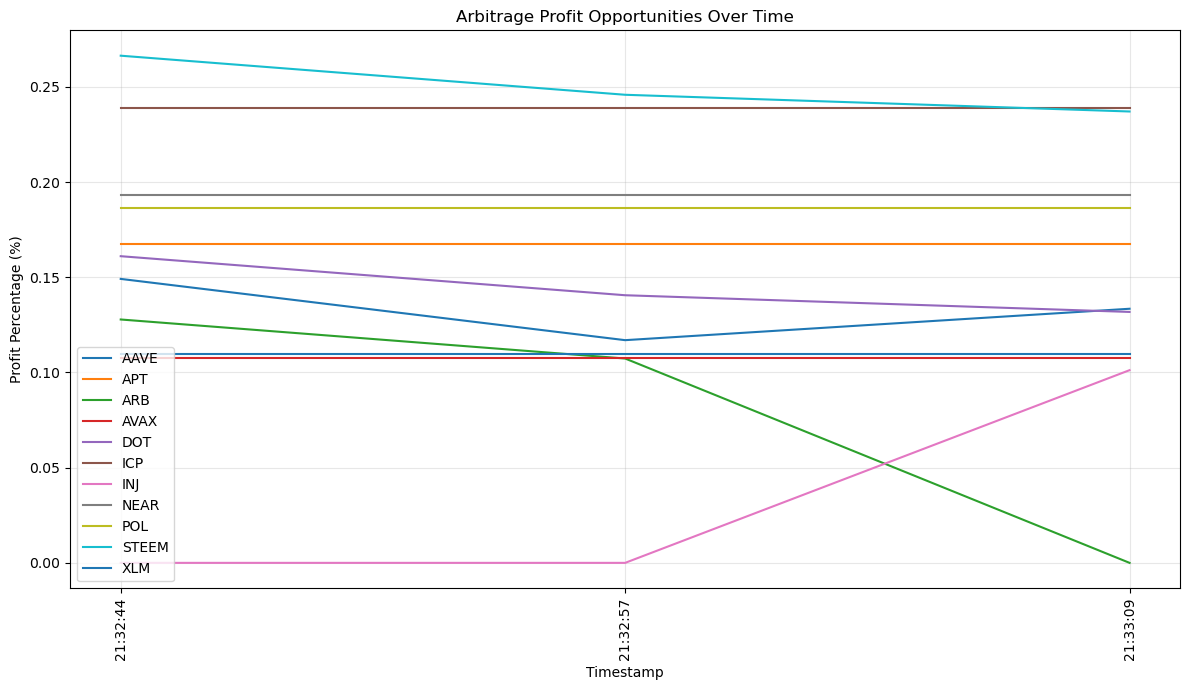

In [5]:
final_df = pd.DataFrame()
for snapshot in arbitrage_snapshots:
    final_df = pd.concat([final_df, snapshot])
import matplotlib.pyplot as plt
%matplotlib inline
final_df = (
    final_df[['timestamp','coin','profit_percentage']]
    .pivot(index='timestamp', columns='coin', values='profit_percentage')
    .reset_index()
    .fillna(0)
)
# Plot all coins with line and marker style
plt.figure(figsize=(12,7))
for coin in final_df.columns[1:]:  # Skip timestamp column
    plt.plot(final_df['timestamp'], final_df[coin], linestyle='-', label=coin)
plt.xticks(rotation=90)
plt.xlabel('Timestamp')
plt.ylabel('Profit Percentage (%)')
plt.title('Arbitrage Profit Opportunities Over Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show();



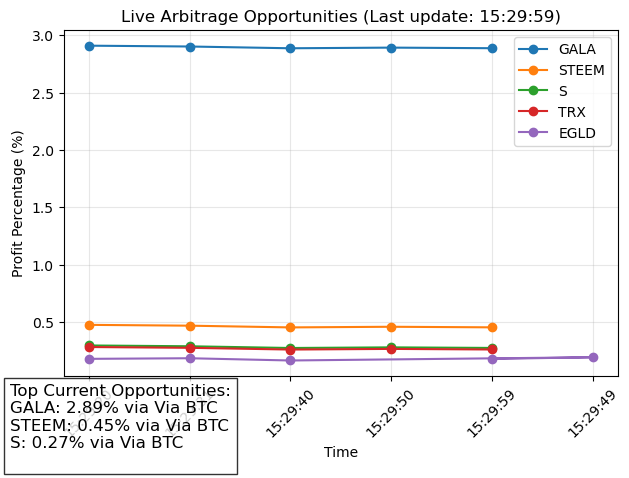

Update 5/100 - Press Ctrl+C to stop
Live monitoring stopped by user.


RuntimeError: This event loop is already running

In [14]:
import asyncio
from IPython.display import clear_output
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pandas as pd

# Create a DataFrame to store all arbitrage data
live_arbitrage_data = pd.DataFrame()

def live_arbitrage_monitor(update_interval=5, max_updates=100):
    """
    Live monitor for arbitrage opportunities that updates every few seconds
    
    Args:
        update_interval: Number of seconds between updates
        max_updates: Maximum number of updates before stopping
    """
    global live_arbitrage_data
    
    plt.figure(figsize=(14, 8))
    
    try:
        for i in range(max_updates):
            # Get fresh data
            snapshot = collect_arbitrage_snapshot()
            
            # Add to our running dataset
            live_arbitrage_data = pd.concat([live_arbitrage_data, snapshot])
            
            # Clear previous output and plot the new data
            clear_output(wait=True)
            
            # Create the plot
            plt.clf()
            
            # Get the top 5 coins with highest profit percentage
            top_coins = live_arbitrage_data['coin'].value_counts().head(5).index.tolist()
            
            # Plot each top coin
            for coin in top_coins:
                coin_data = live_arbitrage_data[live_arbitrage_data['coin'] == coin]
                if len(coin_data) > 1:  # Need at least 2 points to plot a line
                    plt.plot(coin_data['timestamp'], coin_data['profit_percentage'], 
                            marker='o', linestyle='-', label=coin)
            
            plt.title(f'Live Arbitrage Opportunities (Last update: {datetime.now().strftime("%H:%M:%S")})')
            plt.xlabel('Time')
            plt.ylabel('Profit Percentage (%)')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Show top current opportunities in text
            current_top = snapshot.head(3)  # Top 3 current opportunities
            if not current_top.empty:
                opportunity_text = "Top Current Opportunities:\n"
                for _, row in current_top.iterrows():
                    opportunity_text += f"{row['coin']}: {row['profit_percentage']:.2f}% via {row['best_path']}\n"
                plt.figtext(0.02, 0.02, opportunity_text, fontsize=12, 
                            bbox=dict(facecolor='white', alpha=0.8))
            
            plt.draw()
            plt.pause(0.1)  # Small pause to allow the plot to update
            
            print(f"Update {i+1}/{max_updates} - Press Ctrl+C to stop")
            
            # Wait for next update
            time.sleep(update_interval)
            
    except KeyboardInterrupt:
        print("Live monitoring stopped by user.")
    finally:
        plt.close()

# Function to start the live monitoring
def start_live_monitor(update_interval=5):
    """Start the live arbitrage monitor with the specified update interval"""
    loop = asyncio.get_event_loop()
    try:
        loop.run_until_complete(live_arbitrage_monitor(update_interval=update_interval))
    except KeyboardInterrupt:
        print("Live monitoring stopped.")
if __name__ == "__main__":
    start_live_monitor(update_interval=5)

## Correlation analysis

In [21]:
import os
from dotenv import load_dotenv
from binance.client import Client
load_dotenv()
api_key = os.getenv('BinanceAPIKey')
api_secret = os.getenv('BinanceAPISecret')
client = Client(api_key, api_secret)
tickers = client.get_all_tickers()
ticker = tickers[0]
symbol = ticker['symbol']
price = ticker['price']
# Get symbol info (trading pair metadata)
symbol_info = client.get_symbol_info(symbol)
print(f"Symbol info for {symbol}:")
print(symbol_info)

# For coin fundamentals, we need to use different endpoints
# Get coin info using the Binance Coin Info API
try:
    # Get coin details
    coin_info = client.get_coin_info()  # Gets info for all coins
    
    # Extract the base asset from the symbol (e.g., BTC from BTCUSDT)
    base_asset = symbol_info['baseAsset'] if symbol_info else symbol.rstrip('USDT').rstrip('BUSD').rstrip('BTC')
    
    print(f"\nCoin fundamentals for {base_asset}:")
    if base_asset in coin_info:
        coin_data = coin_info[base_asset]
        print(f"Name: {coin_data.get('name', 'N/A')}")
        print(f"Market Cap: {coin_data.get('marketCap', 'N/A')}")
        print(f"Total Supply: {coin_data.get('totalSupply', 'N/A')}")
        print(f"Max Supply: {coin_data.get('maxSupply', 'N/A')}")
        print(f"Circulating Supply: {coin_data.get('circulatingSupply', 'N/A')}")
    else:
        print(f"No detailed information available for {base_asset}")
        
    # For more detailed information, you might need to use CoinMarketCap or CoinGecko APIs
    print("\nNote: For more comprehensive fundamentals like technology details and categorization,")
    print("consider using external APIs like CoinMarketCap or CoinGecko.")
except Exception as e:
    print(f"Error fetching coin fundamentals: {e}")
    print("Note: Some Binance API endpoints may require higher API access levels.")
    print("Consider using CoinMarketCap or CoinGecko APIs for detailed coin fundamentals.")





Symbol info for ETHBTC:
{'symbol': 'ETHBTC', 'status': 'TRADING', 'baseAsset': 'ETH', 'baseAssetPrecision': 8, 'quoteAsset': 'BTC', 'quotePrecision': 8, 'quoteAssetPrecision': 8, 'baseCommissionPrecision': 8, 'quoteCommissionPrecision': 8, 'orderTypes': ['LIMIT', 'LIMIT_MAKER', 'MARKET', 'STOP_LOSS', 'STOP_LOSS_LIMIT', 'TAKE_PROFIT', 'TAKE_PROFIT_LIMIT'], 'icebergAllowed': True, 'ocoAllowed': True, 'otoAllowed': True, 'quoteOrderQtyMarketAllowed': True, 'allowTrailingStop': True, 'cancelReplaceAllowed': True, 'amendAllowed': True, 'isSpotTradingAllowed': True, 'isMarginTradingAllowed': True, 'filters': [{'filterType': 'PRICE_FILTER', 'minPrice': '0.00001000', 'maxPrice': '922327.00000000', 'tickSize': '0.00001000'}, {'filterType': 'LOT_SIZE', 'minQty': '0.00010000', 'maxQty': '100000.00000000', 'stepSize': '0.00010000'}, {'filterType': 'ICEBERG_PARTS', 'limit': 10}, {'filterType': 'MARKET_LOT_SIZE', 'minQty': '0.00000000', 'maxQty': '1124.97009665', 'stepSize': '0.00000000'}, {'filterT

In [22]:

tickers = [i['symbol'] for i in client.get_all_tickers()]
tickers = [i for i in tickers if i.endswith('USDT')]
len(tickers)

585

TypeError: get_tickers_df() missing 2 required positional arguments: 'client' and 'overview_df'

In [26]:
from tqdm import tqdm
record_hist = pd.DataFrame(columns = ['Coin'])
# record_hist = pd.read_csv('history.csv')
counter = 0
for coin in tqdm(tickers, desc="Processing coins"):
    if coin in record_hist['Coin'].unique():
        continue
    else:
        howLong = 365
        # Calculate the timestamps for the binance api function
        untilThisDate = datetime.datetime.now()
        sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
        # Execute the query from binance - timestamps must be converted to strings !
        candle = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1DAY, str(sinceThisDate), str(untilThisDate))

        # Create a dataframe to label all the columns returned by binance so we work with them later.
        df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
        # as timestamp is returned in ms, let us convert this back to proper timestamps.
        df.dateTime = pd.to_datetime(df.dateTime, unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
        df.set_index('dateTime', inplace=True)
        df['close'] = df['close'].astype(float)
        df['Coin'] = coin
        df.reset_index(inplace = True)
        record_hist = pd.concat([record_hist, df])
        record_hist.to_csv('history.csv', index=False)
    counter += 1

client.get_historical_klines()
# Get rid of columns we do not need
df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)


Processing coins:  64%|██████▍   | 375/585 [12:22<11:30,  3.29s/it]/var/folders/q4/th5t139s3l718zzjr35d9jpc0000gr/T/ipykernel_62710/2255621052.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  record_hist = pd.concat([record_hist, df])
Processing coins:  66%|██████▌   | 385/585 [12:52<10:14,  3.07s/it]/var/folders/q4/th5t139s3l718zzjr35d9jpc0000gr/T/ipykernel_62710/2255621052.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  record_hist = pd.concat([record_hist, df])
Processing coins:  67%

TypeError: Client.get_historical_klines() missing 2 required positional arguments: 'symbol' and 'interval'

In [27]:
pd.read_csv('history.csv')


,Coin,dateTime,open,high,low,close,volume,closeTime,quoteAssetVolume,numberOfTrades,takerBuyBaseVol,takerBuyQuoteVol,ignore
0,BTCUSDT,2024-05-23 00:00:00,69166.62000,70096.12000,66312.16000,67969.65000,4.051317e+04,1.716509e+12,2.766790e+09,1827855.0,1.979115e+04,1.351640e+09,0
1,BTCUSDT,2024-05-24 00:00:00,67969.66000,69250.00000,66600.12000,68549.99000,2.809584e+04,1.716595e+12,1.906439e+09,1165907.0,1.434430e+04,9.734574e+08,0
2,BTCUSDT,2024-05-25 00:00:00,68549.99000,69610.00000,68500.00000,69290.57000,1.213039e+04,1.716682e+12,8.373398e+08,703803.0,5.851960e+03,4.039549e+08,0
3,BTCUSDT,2024-05-26 00:00:00,69290.56000,69562.23000,68128.01000,68507.67000,1.187212e+04,1.716768e+12,8.189149e+08,722849.0,5.934621e+03,4.094111e+08,0
4,BTCUSDT,2024-05-27 00:00:00,68507.67000,70687.56000,68250.00000,69436.43000,2.313693e+04,1.716854e+12,1.604722e+09,1219341.0,1.170962e+04,8.121723e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141682,AWEUSDT,2025-05-21 00:00:00,0.07042,0.07150,0.06000,0.06785,1.219918e+08,1.747872e+12,8.201681e+06,84535.0,6.707850e+07,4.528438e+06,0
141683,AWEUSDT,2025-05-22 00:00:00,0.06783,0.07188,0.06713,0.06945,5.668873e+07,1.747958e+12,3.948096e+06,54213.0,2.870045e+07,1.997290e+06,0
141684,HAEDALUSDT,2025-05-21 00:00:00,0.10310,0.22630,0.10310,0.17770,3.694646e+08,1.747872e+12,7.060854e+07,298987.0,1.826809e+08,3.501223e+07,0
141685,HAEDALUSDT,2025-05-22 00:00:00,0.17770,0.20930,0.17150,0.18220,2.491606e+08,1.747958e+12,4.673390e+07,218141.0,1.228021e+08,2.304139e+07,0


In [262]:
record_hist = pd.read_csv('history.csv')
df = (
    record_hist[['dateTime','close','Coin']]
    .pivot_table(index = 'dateTime', columns = ['Coin'], values = 'close')
    .reset_index()
)
asset = 'BTCUSDT'
lag = 3

# Calculate returns for all assets
returns = df.set_index('dateTime').pct_change()
returns
# # Shift the target asset returns by the specified lag
target_returns = returns[asset].shift(-lag)  # Negative lag to look forward

# # Calculate correlation of all assets with the target asset at the specified lag
correlations = returns.corrwith(target_returns)

# # Sort correlations to see most correlated assets
sorted_correlations = correlations.sort_values(ascending=False)
print(f"Correlation of all assets with {asset} at {lag}-day lag:")
sorted_correlations.reset_index()

Correlation of all assets with BTCUSDT at 3-day lag:


,Coin,0
0,REDUSDT,0.409923
1,SHELLUSDT,0.311536
2,LAYERUSDT,0.299186
3,KAITOUSDT,0.215741
4,BERAUSDT,0.212709
...,...,...
437,FTMUSDT,-0.085678
438,USUALUSDT,-0.115267
439,FDUSDUSDT,-0.139215
440,1000CHEEMSUSDT,-0.217104


<Axes: xlabel='dateTime'>

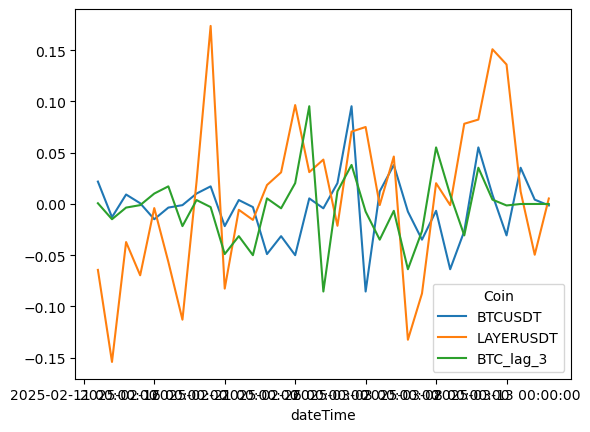

In [277]:
temp = df[['dateTime','BTCUSDT','LAYERUSDT']].dropna().set_index('dateTime')
temp[f'BTC_lag_{lag}'] = temp['BTCUSDT'].shift(-lag)
temp.pct_change().plot()
# .dropna().set_index('dateTime').pct_change().plot()

In [278]:
# [json_data['data'][i]['name'] for i in range(len(json_data['data']))]
# Create a DataFrame with all coin data
url = "https://www.binance.com/bapi/apex/v1/friendly/apex/marketing/complianceSymbolList"
import requests
import json
response = requests.get(url)
json_data = json.loads(response.text)

coin_data = []
for i in range(len(json_data['data'])):
    try:
        coin_info = {
            'Coin': json_data['data'][i].get('name', 'N/A'),
            'Symbol': json_data['data'][i].get('baseAsset', 'N/A'),
            'Circulating Supply': json_data['data'][i].get('circulatingSupply', 0),
            'Max Supply': json_data['data'][i].get('maxSupply', 0),
            'Total Supply': json_data['data'][i].get('totalSupply', 0),
            'Price': json_data['data'][i].get('price', 0),
            'Market Cap': json_data['data'][i].get('marketCap', 0)
        }
        
        # Add tags as separate columns
        tags = json_data['data'][i].get('tags', [])
        for tag in tags:
            coin_info[f'Tag_{tag}'] = True
            
        coin_data.append(coin_info)
    except Exception as e:
        print(f"Error processing coin at index {i}: {e}")

# Create DataFrame
coins_df = pd.DataFrame(coin_data)

# Fill NaN values in tag columns with False
tag_columns = [col for col in coins_df.columns if col.startswith('Tag_')]
coins_df[tag_columns] = coins_df[tag_columns].fillna(False)

# Display the DataFrame
print(f"Total coins in dataset: {len(coins_df)}")
coins_df.head()


Total coins in dataset: 399


,Coin,Symbol,Circulating Supply,Max Supply,Total Supply,Price,Market Cap,Tag_Meme,Tag_Seed,Tag_bnbchain,...,Tag_Infrastructure,Tag_Monitoring,Tag_NFT,Tag_Metaverse,Tag_Launchpad,Tag_liquid_staking,Tag_pow,Tag_storage-zone,Tag_RWA,Tag_Megadrop
0,1000CAT,1000CAT,8087500000,9.000000e+09,8099953034,8.137167e-06,6.580934e+07,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1000CHEEMS,1000CHEEMS,187495034775,2.036730e+11,203672952645,1.128374e-06,2.115645e+08,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,1000SATS,1000SATS,2100000000000,2.100000e+12,2100000000000,1.218711e-07,2.559293e+08,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,1INCH,1INCH,1397500000,NaN,1500000000,2.011147e-01,2.810578e+08,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1MBABYDOGE,1MBABYDOGE,174827049090,NaN,202637678424,1.289128e-09,2.253745e+08,True,True,False,...,False,False,False,False,False,False,False,False,False,False


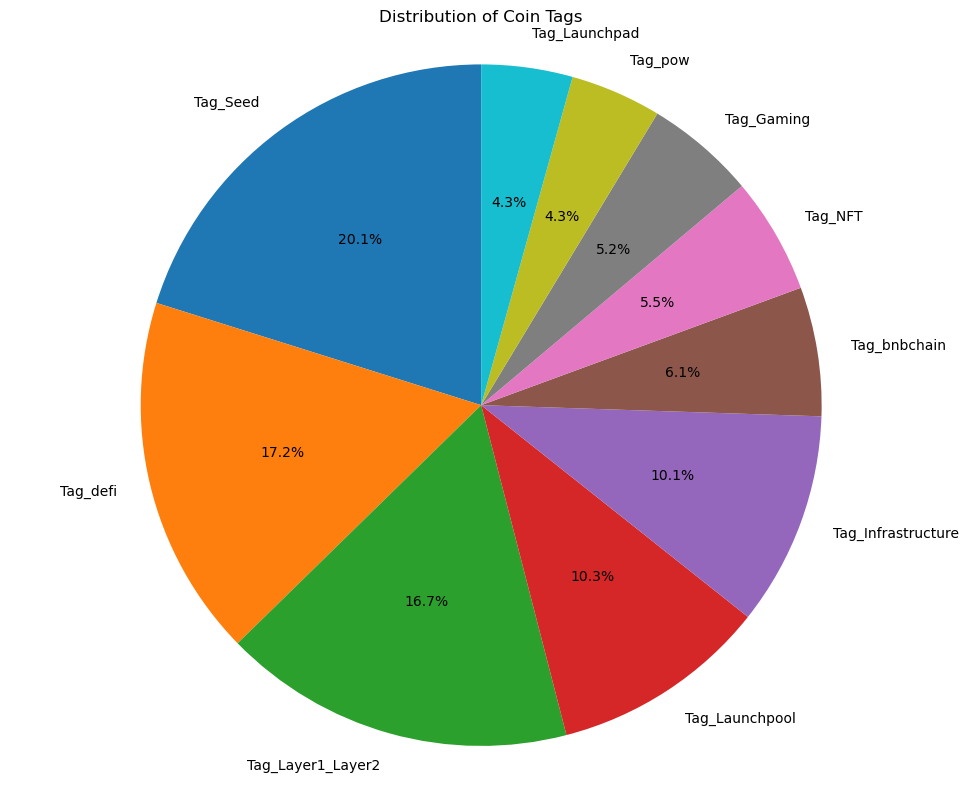

In [284]:
# Get tag counts
tag_counts = coins_df[[col for col in coins_df.columns if 'Tag_' in col]].sum(axis=0).reset_index().sort_values(by=0, ascending=False).head(10)
# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(tag_counts[0], labels=tag_counts['index'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Coin Tags')
plt.tight_layout()
plt.show()

In [185]:
top100 = coins_df.sort_values(by='Market Cap', ascending=False)

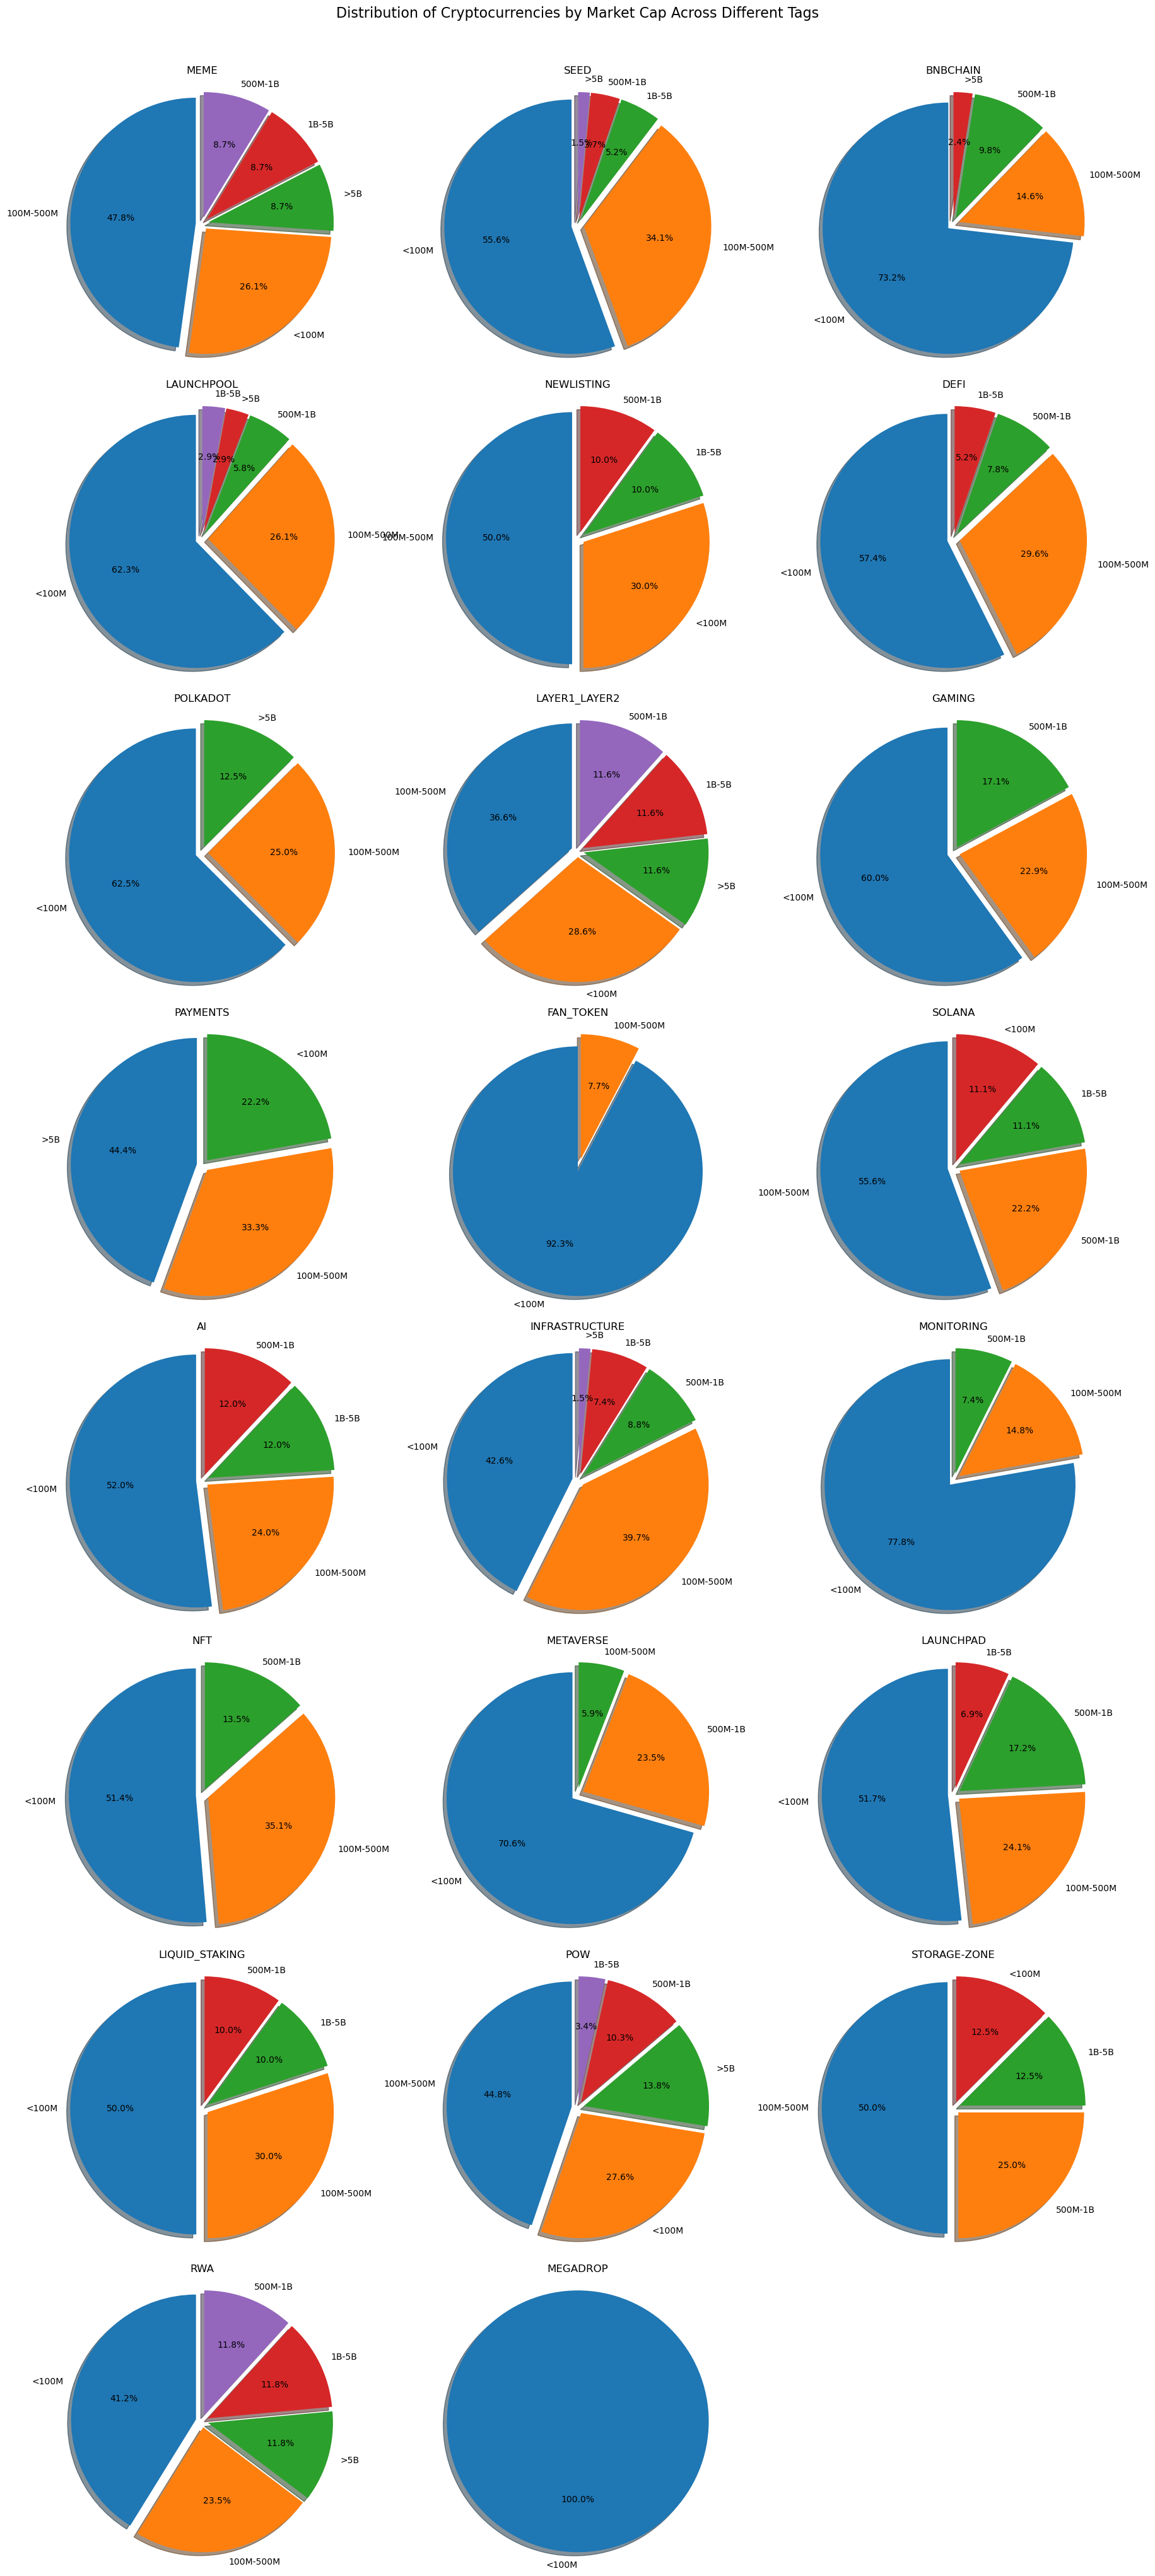

In [186]:
# Disable pandas SettingWithCopyWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Disable the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Define market cap buckets in millions
buckets = [
    (0, 100, '<100M'),
    (100, 500, '100M-500M'),
    (500, 1000, '500M-1B'),
    (1000, 5000, '1B-5B'),
    (5000, float('inf'), '>5B')
]
tags = [i for i in coins_df.columns if i.startswith('Tag_')]

# Create a figure with subplots in a grid
num_tags = len(tags)
rows = int(np.ceil(num_tags / 3))  # 3 charts per row
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Function to categorize market cap
def categorize_market_cap(cap):
    for lower, upper, label in buckets:
        if lower <= cap < upper:
            return label
    return 'Unknown'

# Create pie charts for each tag
for idx, tag in enumerate(tags):
    if idx < len(axes):  # Make sure we don't exceed the number of subplots
        temp_df = top100[top100[tag] == True]
        # Convert market cap to millions for easier reading
        temp_df['Market Cap (M)'] = temp_df['Market Cap'] / 1e6
        temp_df['Market Cap Category'] = temp_df['Market Cap (M)'].apply(categorize_market_cap)
        
        # Count coins in each bucket
        market_cap_distribution = temp_df['Market Cap Category'].value_counts()
        
        # Create pie chart in the corresponding subplot
        if len(market_cap_distribution) > 0:  # Only plot if there's data
            axes[idx].pie(market_cap_distribution, labels=market_cap_distribution.index, 
                         autopct='%1.1f%%', startangle=90, shadow=True, 
                         explode=[0.05] * len(market_cap_distribution))
            axes[idx].set_title(f'{tag.replace("Tag_", "").upper()}')
            axes[idx].axis('equal')  # Equal aspect ratio

# Hide any unused subplots
for idx in range(len(tags), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Distribution of Cryptocurrencies by Market Cap Across Different Tags', 
             fontsize=16, y=1.02)
plt.show()

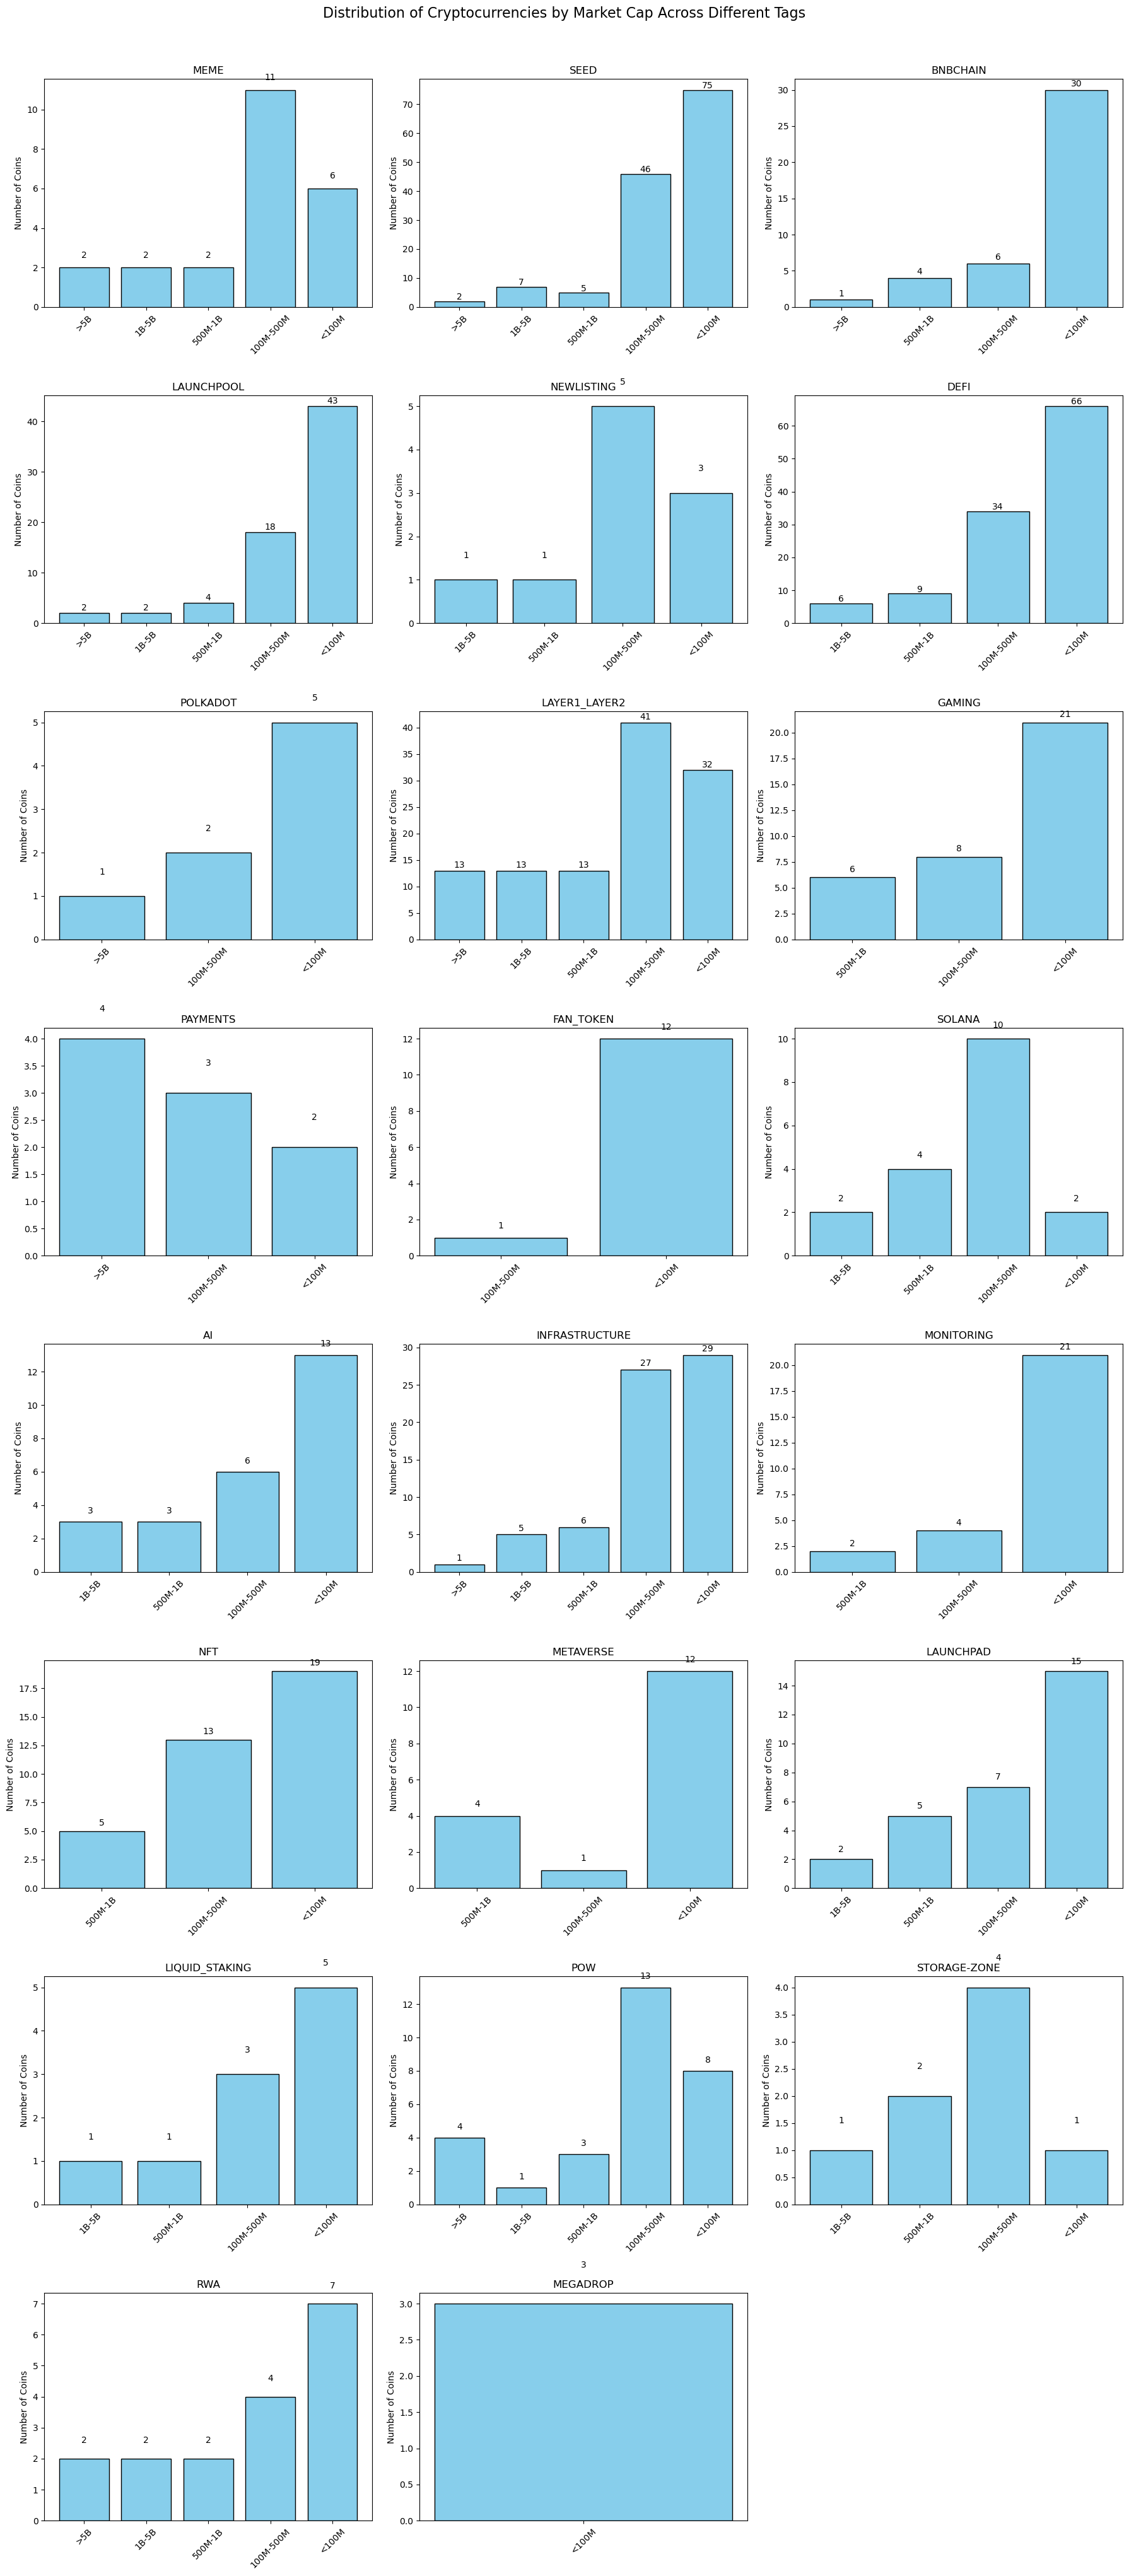

In [188]:
# Disable pandas SettingWithCopyWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Disable the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Define market cap buckets in millions
buckets = [
    (0, 100, '<100M'),
    (100, 500, '100M-500M'),
    (500, 1000, '500M-1B'),
    (1000, 5000, '1B-5B'),
    (5000, float('inf'), '>5B')
]
tags = [i for i in coins_df.columns if i.startswith('Tag_')]

# Create a figure with subplots in a grid
num_tags = len(tags)
rows = int(np.ceil(num_tags / 3))  # 3 charts per row
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Function to categorize market cap
def categorize_market_cap(cap):
    for lower, upper, label in buckets:
        if lower <= cap < upper:
            return label
    return 'Unknown'

# Define the order for market cap categories (from highest to lowest)
category_order = ['>5B', '1B-5B', '500M-1B', '100M-500M', '<100M']

# Create histograms for each tag
for idx, tag in enumerate(tags):
    if idx < len(axes):  # Make sure we don't exceed the number of subplots
        temp_df = top100[top100[tag] == True]
        # Convert market cap to millions for easier reading
        temp_df['Market Cap (M)'] = temp_df['Market Cap'] / 1e6
        temp_df['Market Cap Category'] = temp_df['Market Cap (M)'].apply(categorize_market_cap)
        
        # Count coins in each bucket
        market_cap_distribution = temp_df['Market Cap Category'].value_counts()
        
        # Create histogram in the corresponding subplot
        if len(market_cap_distribution) > 0:  # Only plot if there's data
            # Reindex to ensure proper order and include only categories that exist in our data
            categories_present = [cat for cat in category_order if cat in market_cap_distribution.index]
            ordered_distribution = market_cap_distribution.reindex(categories_present)
            
            # Plot the histogram
            axes[idx].bar(ordered_distribution.index, ordered_distribution.values, 
                         color='skyblue', edgecolor='black')
            axes[idx].set_title(f'{tag.replace("Tag_", "").upper()}')
            axes[idx].set_ylabel('Number of Coins')
            axes[idx].tick_params(axis='x', rotation=45)
            
            # Add count labels on top of each bar
            for i, v in enumerate(ordered_distribution.values):
                axes[idx].text(i, v + 0.5, str(v), ha='center')

# Hide any unused subplots
for idx in range(len(tags), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Distribution of Cryptocurrencies by Market Cap Across Different Tags', 
             fontsize=16, y=1.02)
plt.show()

In [200]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Get all available tickers from yfinance
# Alternative approach:
# stock_info = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# tickers = stock_info['Symbol'].tolist()
# yf.download('BNB-USD', start='2023-01-01', end='2023-12-31', multi_level_index=False).reset_index()

{}

In [317]:
def get_lagged_correlations(coin, lag, df=df):
    """
    Calculate correlations between a specified coin and lagged values of all other coins.
    
    Parameters:
    -----------
    coin : str
        The ticker symbol of the coin to correlate against (e.g., 'BTCUSDT')
    lag : int
        Number of periods to lag other coins (positive values = future values)
    df : pandas.DataFrame, optional
        DataFrame containing price data. If None, will use the previously loaded data
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with correlations between the specified coin and lagged values of all other coins
    """
    copied = df.copy()
    lagged_col_name = f'{coin}_lag_{lag}'
    copied[lagged_col_name] = copied[coin].shift(-lag)
    copied = copied.set_index('dateTime')
    copied = copied.pct_change()
    # print(copied)
    correlations = copied.corr()
    correlations = correlations[lagged_col_name]
    correlations = correlations.sort_values(ascending=False)
    
    return correlations.reset_index()

# Example usage:
# Get correlations between BTCUSDT and all other coins lagged by 1 day
btc_correlations = get_lagged_correlations('BTCUSDT', 10)
btc_correlations


,Coin,BTCUSDT_lag_10
0,BTCUSDT_lag_10,1.000000
1,KAITOUSDT,0.340983
2,SHELLUSDT,0.322801
3,1000CHEEMSUSDT,0.306036
4,BERAUSDT,0.298681
...,...,...
438,CLVUSDT,-0.076438
439,BARUSDT,-0.082383
440,USDCUSDT,-0.086846
441,BELUSDT,-0.122508


In [321]:
def find_btc_follower_coins(max_lag=5, df=df):
    """
    Find coins that follow BTC's price movements with a delay.
    
    Parameters:
    -----------
    max_lag : int
        Maximum number of days to check for delayed reactions
    df : pandas.DataFrame
        DataFrame containing price data with 'dateTime' column and coin prices
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame showing each coin's correlation with BTC at different lag periods
    """
    # Make a copy of the dataframe and set index
    price_data = df.copy().set_index('dateTime')
    
    # Calculate daily returns
    returns = price_data.pct_change().fillna(0)
    
    # Initialize results dictionary
    results = {}
    
    # Bitcoin's returns as the leading indicator
    btc_returns = returns['BTCUSDT']
    
    # Check each coin
    for coin in returns.columns:
        if coin != 'BTCUSDT':  # Skip Bitcoin itself
            coin_correlations = []
            
            # Check correlation at different lags
            for lag in range(max_lag + 1):
                # Shift the coin's returns by the lag amount
                # lag=0 means same-day correlation
                # lag=1 means coin follows BTC with 1-day delay, etc.
                lagged_coin_returns = returns[coin].shift(-lag)
                
                # Calculate correlation between current BTC and future coin
                correlation = btc_returns.corr(lagged_coin_returns)
                coin_correlations.append(correlation)
            
            results[coin] = coin_correlations
    
    # Create DataFrame from results
    lag_columns = [f'Lag_{i}_day' for i in range(max_lag + 1)]
    result_df = pd.DataFrame.from_dict(results, orient='index', columns=lag_columns)
    
    # Add column showing best lag period for each coin
    result_df['Best_Lag'] = result_df.iloc[:, :max_lag + 1].idxmax(axis=1)
    result_df['Max_Correlation'] = result_df.iloc[:, :max_lag + 1].max(axis=1)
    
    # Sort by maximum correlation value
    return result_df.sort_values('Max_Correlation', ascending=False)

find_btc_follower_coins(max_lag=5, df=df)

,Lag_0_day,Lag_1_day,Lag_2_day,Lag_3_day,Lag_4_day,Lag_5_day,Best_Lag,Max_Correlation
WBTCUSDT,0.999269,-0.054038,0.005101,-0.061420,0.030630,-0.016512,Lag_0_day,0.999269
ETHUSDT,0.814204,-0.040724,0.043915,0.016545,-0.030557,-0.008661,Lag_0_day,0.814204
WBETHUSDT,0.813495,-0.041584,0.043899,0.016693,-0.030581,-0.010238,Lag_0_day,0.813495
DOGEUSDT,0.804987,0.022656,0.024040,-0.051858,0.040495,-0.027953,Lag_0_day,0.804987
NEXOUSDT,0.784791,-0.089270,0.011786,-0.019280,0.010562,-0.060103,Lag_0_day,0.784791
...,...,...,...,...,...,...,...,...
USDPUSDT,-0.166275,0.084279,0.024874,-0.065000,0.061184,-0.077946,Lag_1_day,0.084279
MOBUSDT,-0.021309,0.057366,-0.015700,0.006256,0.073809,0.063735,Lag_4_day,0.073809
TSTUSDT,0.068618,-0.063384,0.010523,0.034273,-0.028945,0.014744,Lag_0_day,0.068618
PNTUSDT,-0.032206,0.044115,-0.003206,0.007245,0.061297,0.001330,Lag_4_day,0.061297
